## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.shape

(1338, 7)

#### Show Top 5 Records

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Preparing X and Y variables

In [5]:
X = df.drop(columns=['charges'],axis=1)

In [6]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [7]:
print("Categories in 'sex' variable:     ",end=" " )
print(df['sex'].unique())

print("Categories in 'smoker' variable:  ",end=" ")
print(df['smoker'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['region'].unique())


Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'parental level of education' variable: ['southwest' 'southeast' 'northwest' 'northeast']


In [8]:
y = df['charges']

In [9]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [10]:
# Create Column Transformer with 3 types of transformers

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
import pickle

# Define categorical and numerical features
cat_features = ["sex", "smoker", "region"]
num_features = ["age", "bmi", "children"]

# Define the preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_features),
    ("num", StandardScaler(), num_features)
])



In [11]:
print("Skewness before Transformation:", y.skew())

Skewness before Transformation: 1.5158796580240388


In [12]:
pt_y = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform and convert back to a Pandas Series
y_transformed = pd.Series(pt_y.fit_transform(y.values.reshape(-1, 1)).flatten())

# Compute skewness
print("Skewness After Transformation:", y_transformed.skew())

    

Skewness After Transformation: -0.008708879288064627


In [13]:
X = preprocessor.fit_transform(X)

# Fit the preprocessor to the training data

# Save the preprocessor along with the model
# with open('preprocessor.pkl', 'wb') as file:
#     pickle.dump(X, file)

# print("Preprocessor saved as 'preprocessor.pkl'.")

In [14]:
X.shape

(1338, 11)

In [15]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1070, 11), (268, 11))

#### Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [17]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin

# class CustomCatBoostRegressor(CatBoostRegressor, BaseEstimator, RegressorMixin):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

# class CustomXGBRegressor(XGBRegressor, BaseEstimator, RegressorMixin):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    'Support Vector Machine': SVR()
}

model_list = []
r2_list = []
cv_r2_list = []

for name, model in models.items():
    print(f"Training {name}...")

    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on Train/Test Split
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Perform Cross-Validation
    cv_scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=kf, n_jobs=-1)
    mean_cv_r2 = np.mean(cv_scores)

    # Store Results
    model_list.append(name)
    r2_list.append(model_test_r2)
    cv_r2_list.append(mean_cv_r2)
    
    # Print Results
    
    print(f"{name} - Model performance for Training set")
    print(f"- RMSE: {model_train_rmse:.4f}")
    print(f"- MAE: {model_train_mae:.4f}")
    print(f"- R2 Score: {model_train_r2:.4f}\n")
    
    print(f"{name} - Model performance for Test set")
    print(f"- RMSE: {model_test_rmse:.4f}")
    print(f"- MAE: {model_test_mae:.4f}")
    print(f"- R2 Score: {model_test_r2:.4f}")
    
    print(f"{name} - Cross-Validation R2 Scores: {cv_scores}")
    print(f"{name} - Mean R2 (CV): {mean_cv_r2:.4f}")
    
    print('=' * 40)
    print('\n')

# Create DataFrame for Comparison
results_df = pd.DataFrame({
    'Model': model_list,
    'Test R2 (Hold-out)': r2_list,
    'Mean R2 (Cross-Validation)': cv_r2_list
})

# Sort by CV Score
results_df = results_df.sort_values(by='Mean R2 (Cross-Validation)', ascending=False)



Training Linear Regression...
Linear Regression - Model performance for Training set
- RMSE: 0.4877
- MAE: 0.3066
- R2 Score: 0.7580

Linear Regression - Model performance for Test set
- RMSE: 0.4582
- MAE: 0.2943
- R2 Score: 0.8027
Linear Regression - Cross-Validation R2 Scores: [0.82163164 0.86268786 0.76883485 0.7853647  0.7352251 ]
Linear Regression - Mean R2 (CV): 0.7947


Training Lasso...
Lasso - Model performance for Training set
- RMSE: 0.9913
- MAE: 0.7956
- R2 Score: 0.0000

Lasso - Model performance for Test set
- RMSE: 1.0347
- MAE: 0.8517
- R2 Score: -0.0057
Lasso - Cross-Validation R2 Scores: [-4.57310043e-04 -8.34175948e-04 -4.66391676e-04 -1.52158565e-03
 -5.57317095e-05]
Lasso - Mean R2 (CV): -0.0007


Training Ridge...
Ridge - Model performance for Training set
- RMSE: 0.4853
- MAE: 0.3056
- R2 Score: 0.7603

Ridge - Model performance for Test set
- RMSE: 0.4531
- MAE: 0.2939
- R2 Score: 0.8072
Ridge - Cross-Validation R2 Scores: [0.82565256 0.86139036 0.76619136 0.7

In [36]:
# Display Results
results_df

,Model,Test R2 (Hold-out),Mean R2 (Cross-Validation)
9,Support Vector Machine,0.857615,0.809835
5,Random Forest Regressor,0.842697,0.805997
7,CatBoosting Regressor,0.856176,0.798936
2,Ridge,0.807179,0.795090
0,Linear Regression,0.802750,0.794749
6,XGBRegressor,0.810403,0.780396
8,AdaBoost Regressor,0.684769,0.737817
3,K-Neighbors Regressor,0.779140,0.692740
4,Decision Tree,0.746516,0.675236
1,Lasso,-0.005719,-0.000667


In [18]:
import sklearn
import catboost
import xgboost

print("scikit-learn version:", sklearn.__version__)
print("CatBoost version:", catboost.__version__)
print("XGBoost version:", xgboost.__version__)

scikit-learn version: 1.5.2
CatBoost version: 1.2.7
XGBoost version: 2.1.3


### Results

In [19]:
model_r2_df = pd.DataFrame(list(zip(model_list, r2_list, cv_r2_list)), columns=['Model Name', 'R2_Score', 'CV_R2_score']).sort_values(by=["CV_R2_score"],ascending=False)
model_r2_df

,Model Name,R2_Score,CV_R2_score
9,Support Vector Machine,0.857615,0.809835
5,Random Forest Regressor,0.842697,0.805997
7,CatBoosting Regressor,0.856176,0.798936
2,Ridge,0.807179,0.795090
0,Linear Regression,0.802750,0.794749
6,XGBRegressor,0.810403,0.780396
8,AdaBoost Regressor,0.684769,0.737817
3,K-Neighbors Regressor,0.779140,0.692740
4,Decision Tree,0.746516,0.675236
1,Lasso,-0.005719,-0.000667


## Linear Regression

In [20]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 80.27


## Plot y_pred and y_test

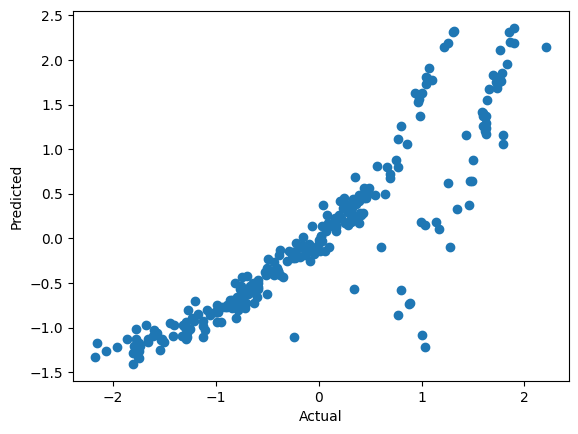

In [21]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

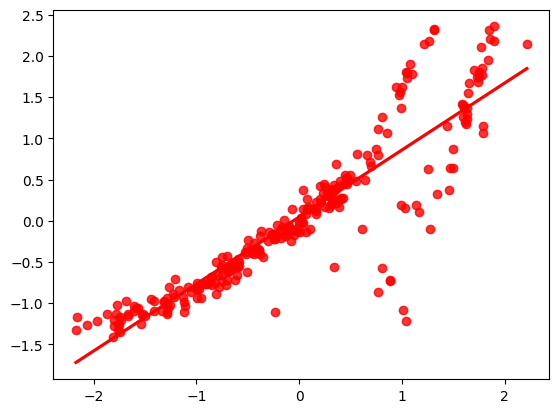

In [22]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [23]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
764,-0.001730,-0.015625,0.013895
887,-0.588942,-0.500000,-0.088942
890,1.307400,2.312500,-1.005100
1293,0.022786,-0.015625,0.038411
259,1.468841,0.640625,0.828216
...,...,...,...
109,1.855095,2.203125,-0.348030
575,0.322462,0.265625,0.056837
535,-0.439037,-0.406250,-0.032787
543,2.213295,2.140625,0.072670


# Ridge Regression

In [24]:
lin_model = Ridge(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 80.72


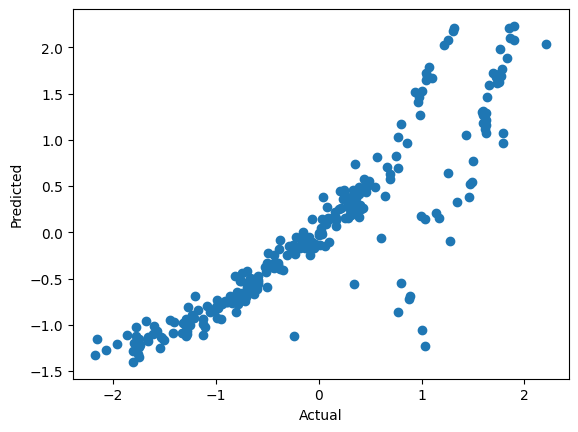

In [25]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

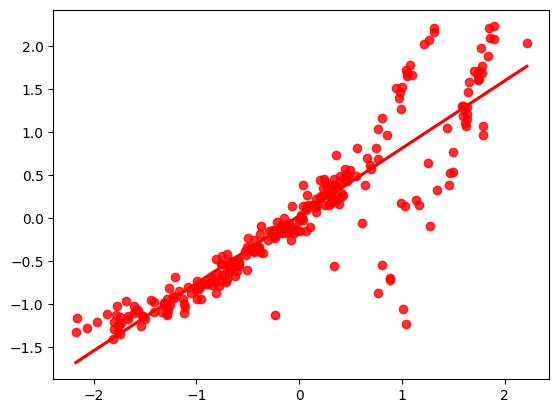

In [26]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [27]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
764,-0.001730,-0.001980,0.000250
887,-0.588942,-0.510553,-0.078389
890,1.307400,2.172114,-0.864714
1293,0.022786,0.003792,0.018994
259,1.468841,0.527077,0.941764
...,...,...,...
109,1.855095,2.103147,-0.248052
575,0.322462,0.250444,0.072018
535,-0.439037,-0.387304,-0.051733
543,2.213295,2.039552,0.173743


In [28]:
cat_model = CatBoostRegressor(verbose=False)
cat_model = cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 85.62


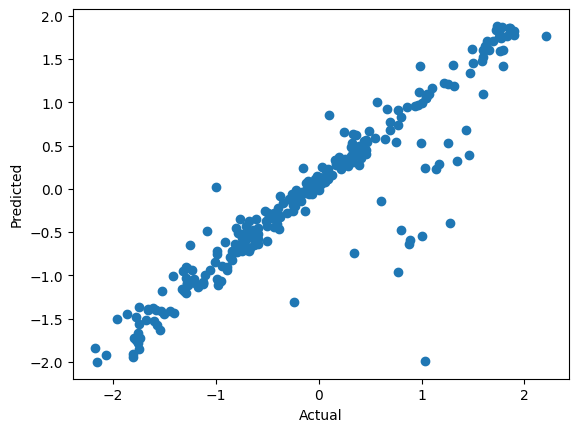

In [29]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

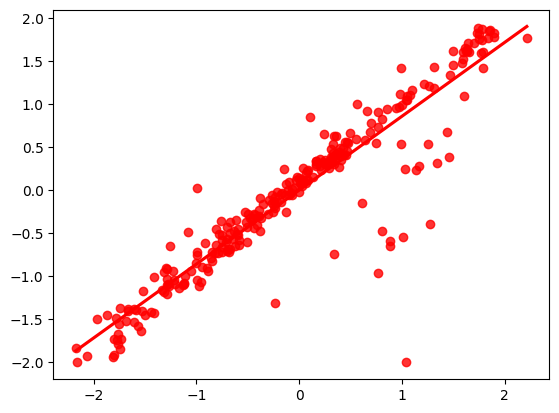

In [30]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [31]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
764,-0.001730,0.141802,-0.143532
887,-0.588942,-0.579691,-0.009251
890,1.307400,1.435524,-0.128124
1293,0.022786,0.050307,-0.027521
259,1.468841,1.334418,0.134423
...,...,...,...
109,1.855095,1.857990,-0.002895
575,0.322462,0.374788,-0.052326
535,-0.439037,-0.438153,-0.000884
543,2.213295,1.763639,0.449656


In [35]:
import pickle

# # Assume the best model has been identified
# best_model_index = r2_list.index(max(cv_r2_list))  # Find index of the best R2 score
# best_model_name = model_list[best_model_index]  # Get the name of the best model
# best_model = models[best_model_name]  # Retrieve the best model instance

best_model_name = model_r2_df.iloc[0, 0] # Get the name of the best model']
best_model_score = model_r2_df.iloc[0, 2]
# Save the trained model
# with open('best_model.pkl', 'wb') as file:
#     pickle.dump(best_model, file)

print(f"The best model '{best_model_name}' with R2 score: {best_model_score}.")


The best model 'Support Vector Machine' with R2 score: 0.809835446768156.
